# SPINE PROBLEMS

## 0 IMPORT LIBRARIES

In [34]:
import polars as pl
import os
import torch
import torch.nn as nn
from dataclasses import dataclass
from typing import Literal
import optuna
from optuna import Study, Trial
import optuna.pruners as pruners
import optuna.samplers as samplers
import optuna.storages as storages
from utils.training import autoencoder_trainer
from pathlib import Path


### 0.1 Set Device

In [35]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the CPU


### 1 GLOBAL SEATINGS

In [36]:
WORKDIR_PATH = "" # "../"
IMAGE_DIM = 256
NO_CACHE = True
CACHE_DIR = WORKDIR_PATH + ".cache/"
DATASET_DIR = WORKDIR_PATH + "dataset/"
ANOTTATIONS_DIR = DATASET_DIR + "annotations/"
TRAIN_DIR = os.path.join(DATASET_DIR, "train_images/")
LOAD_SESSION = False
RESOURCES = "resources/"

## 2 Preprocessing

### 2.2 Load Dataset

In [37]:
from utils import visualice, process_data

lazy_dataset = any
if os.path.exists(CACHE_DIR + "preprocesed_dataset.parquet"):
    print("cache")
    lazy_dataset = pl.scan_parquet(CACHE_DIR + 'preprocesed_dataset.parquet')
    LENGTH = lazy_dataset.select(pl.len()).collect().item()
    NO_CACHE = False
else:
    print("from zero")
    lazy_dataset = pl.scan_csv(ANOTTATIONS_DIR + 'train.csv')
    # lazy_dataset = pl.scan_csv(ANOTTATIONS_DIR + 'p.csv')
    LENGTH = lazy_dataset.select(pl.len()).collect().item()

from zero


In [38]:
if NO_CACHE:
    lesionTypes = lazy_dataset.select(["lesion_type"]).collect().unique().to_series().to_list()
    num_class = len(lesionTypes)
    print(lesionTypes)

['Osteophytes', 'Vertebral collapse', 'Spondylolysthesis', 'Surgical implant', 'Disc space narrowing', 'No finding', 'Foraminal stenosis', 'Other lesions']


### 2.3 Filter dataset 

In [39]:
if NO_CACHE:
    lazy_dataset = (
        lazy_dataset
        .select(['image_id', 'lesion_type'])
    )

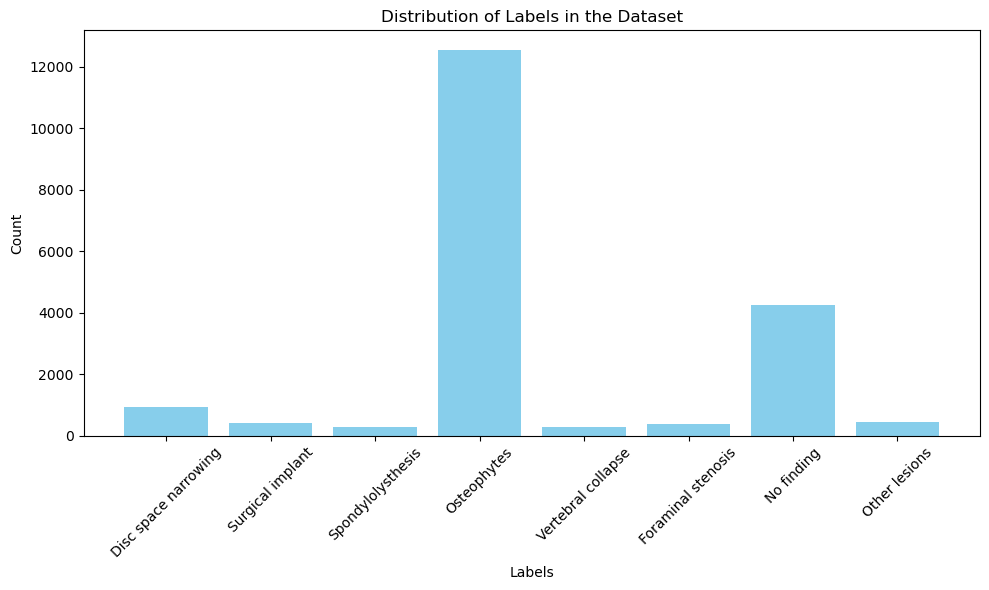

In [43]:
import matplotlib.pyplot as plt

label_counts_pd = (
        lazy_dataset.
        group_by('lesion_type').agg(
    pl.count('image_id').alias('count')
    )
)
# Convert to pandas for easier plotting
label_counts = label_counts_pd.collect()
# Extract data for plotting
labels = label_counts['lesion_type'].to_list()
counts = label_counts['count'].to_list()

# Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Lesions')
plt.ylabel('Count')
plt.title('Distribution of Lesions in the Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Data Aumentation

AttributeError: module 'albumentations' has no attribute 'Flip'

In [ ]:
label_counts_pd = (
        lazy_dataset.
        group_by('lesion_type').agg(
    pl.count('image_id').alias('count')
    )
)
# Convert to pandas for easier plotting
label_counts = label_counts_pd.collect()
# Extract data for plotting
labels = label_counts['lesion_type'].to_list()
counts = label_counts['count'].to_list()

# Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Lesions')
plt.ylabel('Count')
plt.title('Distribution of Lesions in the Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.4 Agrup by lesion type for label classification

In [29]:
if NO_CACHE:
    lazy_dataset = (
        lazy_dataset.group_by("image_id").agg(
        pl.col("lesion_type"))
    )
LENGTH = lazy_dataset.select(pl.len()).collect().item()
print(LENGTH)

8389


### 2.5 Get image path and add to the dataset

In [8]:
if NO_CACHE:
    lazy_dataset = (
        lazy_dataset
        .with_columns((pl.lit(TRAIN_DIR) + (pl.col("image_id")+pl.lit('.dicom'))).alias("image_path"))
        .drop('image_id')
    )

In [27]:
if NO_CACHE:
    lazy_dataset = (lazy_dataset
        .with_columns([
            pl.col('lesion_type')
            .list.unique()  # Remove duplicates within each list
            .alias('lesion_labels')
        ]).drop("lesion_type"))
visualice.visualice_lazyframe(lazy_dataset)

lesion_labels,image
list[str],list[list[f32]]
"[""No finding""]","[[0.838801, 0.845464, … 0.428755], [0.827268, 0.834444, … 0.403127], … [0.424398, 0.436443, … 0.269349]]"
"[""Osteophytes""]","[[0.029147, 0.028875, … 0.034595], [0.029147, 0.028875, … 0.034595], … [0.658131, 0.659766, … 0.713157]]"
"[""Osteophytes"", ""Disc space narrowing""]","[[0.22759, 0.227032, … 0.956716], [0.23122, 0.271991, … 0.958112], … [0.823513, 0.79866, … 0.20162]]"
"[""No finding""]","[[0.042184, 0.040199, … 0.035732], [0.04268, 0.041687, … 0.037965], … [0.087097, 0.101985, … 0.113896]]"
"[""Osteophytes""]","[[0.558062, 0.555834, … 0.588972], [0.554163, 0.551657, … 0.583403], … [0.710944, 0.727652, … 0.501532]]"


### 2.6 Preprocess the data

In [10]:
if NO_CACHE:
    lazy_dataset = (
        lazy_dataset
        .with_columns(
            pl.col("image_path")
            .map_elements(
                function=process_data.preprocess,
                return_dtype=pl.List(pl.List(pl.Float32))
                )
            .alias("image")
        )
        .drop("image_path")
    )
visualice.visualice_lazyframe(lazy_dataset)

lesion_labels,image
list[str],list[list[f32]]
"[""Osteophytes""]","[[1.3461e-10, 1.3461e-10, … 0.728618], [1.3461e-10, 1.3461e-10, … 0.776215], … [0.948479, 0.956055, … 0.957974]]"
"[""No finding""]","[[0.305144, 0.351066, … 0.240903], [0.278795, 0.332999, … 0.237641], … [0.176161, 0.16788, … 0.229611]]"
"[""No finding""]","[[0.059852, 0.059322, … 0.042373], [0.054025, 0.053496, … 0.037871], … [0.00715, 0.00715, … 0.016155]]"
"[""Osteophytes""]","[[0.01915, 0.019431, … 0.1363], [0.024782, 0.025063, … 0.176007], … [0.415939, 0.423543, … 0.603492]]"
"[""Osteophytes""]","[[0.048888, 0.048595, … 0.045667], [0.048888, 0.048009, … 0.0363], … [0.042155, 0.042447, … 0.028689]]"


### 2.7 Save the preprocessed dataset

In [11]:
from utils import create_parquet

if NO_CACHE:
    create_parquet.process_lazy_images(lazy_dataset,total_rows=LENGTH, chunk_size=50, output_path=CACHE_DIR)

Parquet creation process:   0%|          | 0/168 [00:00<?, ?it/s]

### 2.8 Split the dataset

In [12]:
from utils.training import autoencoder_trainer, dataloader

train_dataset, validation_dataset = torch.utils.data.random_split(dataloader.LazyFrameDataset(lazy_frame=lazy_dataset, dataset_length=LENGTH), [0.8, 0.2])

## 3 AUTOENCODER

### 3.1 Covolutional Block

In [13]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate:float, kernel_size:int, activation):
        super().__init__()
        padding = kernel_size // 2
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Dropout2d(dropout_rate)
        )
    def forward(self, x):
        return self.block(x)

### 3.2 Encoder

In [14]:
class Encoder(nn.Module):
    def __init__(self, in_channels:int=1, base_filters:int=64):
        super().__init__()

        self.in_channels = in_channels
        self.base_filters = base_filters

        self.pool = nn.MaxPool2d((2, 2))

        self.level1 = ConvolutionBlock(self.in_channels, self.base_filters,dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
        self.level2 = ConvolutionBlock(self.base_filters, self.base_filters * 2,dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
        self.level3 = ConvolutionBlock(self.base_filters * 2, self.base_filters * 4,dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
        
        self.bottleneck = ConvolutionBlock(self.base_filters * 4, self.base_filters * 8,dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
    def forward(self, x):

        skip_connections = []

        level1_features = self.level1(x)
        skip_connections.append(level1_features)
        level1_pooled = self.pool(level1_features)

        level2_features = self.level2(level1_pooled)
        skip_connections.append(level2_features)
        level2_pooled = self.pool(level2_features)

        level3_features = self.level3(level2_pooled)
        skip_connections.append(level3_features)
        level3_pooled = self.pool(level3_features)

        bottleneck_features = self.bottleneck(level3_pooled)
        return {
            'encoded_image': bottleneck_features,
            'skip_connections': skip_connections
        }

### 3.3 Decoder


In [15]:
class Decoder(nn.Module):
    def __init__(self, in_channels:int=1, base_filters:int=64):
        super().__init__()
        
        self.in_channels = in_channels
        self.base_filters = base_filters * 8
        
        self.upconv1 = nn.ConvTranspose2d(self.base_filters//1, self.base_filters // 2, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(self.base_filters // 2, self.base_filters // 4, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(self.base_filters // 4, self.base_filters // 8, kernel_size=2, stride=2)
        
        self.conv1 = ConvolutionBlock(self.base_filters, self.base_filters // 2, dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
        self.conv2 = ConvolutionBlock(self.base_filters // 2, self.base_filters // 4, dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
        self.conv3 = ConvolutionBlock(self.base_filters // 4, self.base_filters // 8, dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
        self.output_conv = nn.Conv2d(self.base_filters // 8, in_channels, kernel_size=1)
        
    def forward(self, encoder_output):

        features = encoder_output['encoded_image']
        skip_connections = encoder_output['skip_connections']
        up1 = self.upconv1(features)
        up1 = torch.cat([up1, skip_connections[2]], dim=1)
        up1 = self.conv1(up1)

        up2 = self.upconv2(up1)
        up2 = torch.cat([up2, skip_connections[1]], dim=1)
        up2 = self.conv2(up2)

        up3 = self.upconv3(up2)
        up3 = torch.cat([up3, skip_connections[0]], dim=1)
        up3 = self.conv3(up3)

        output = torch.sigmoid(self.output_conv(up3))
        return {"recontruction":output, "encoded_image":encoder_output['encoded_image']}

### 3.4 Autoencoder

In [16]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.encoder.to(device)
        
        self.decoder = decoder
        self.decoder.to(device)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 3.5 Classifier

In [17]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Global Average Pooling to reduce spatial dimensions (64x64 -> 1x1)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
            # Classification head
            # Input will be 512 (from encoder's 512 channels)
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the 512x1x1 to 512
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, encoder):
        # Get encoded representation (shape: [batch, 512, 64, 64])
        encoder_output = encoder(x)
        encoded_features = encoder_output['encoded_image']
        
        # Global average pooling (shape: [batch, 512, 1, 1])
        pooled_features = self.global_pool(encoded_features)
        
        # Get classification logits
        logits = self.classifier(pooled_features)
        return logits

## 4 Model

#### 4.1 Hyperparameter Tuner

In [18]:
@dataclass
class HyperparameterTuner:
    gc_after_trial: bool
    n_jobs: int
    n_trials: int
    timeout: float | None
    tuning_direction: Literal["minimize", "maximize"]
    train_epochs: int | None
    show_progress_bar: bool
    study_load_if_exists: bool
    study_name: str
    study_pruner: optuna.pruners.BasePruner
    study_sampler: optuna.samplers.BaseSampler
    # study_storage: optuna.storages.BaseStorage
    
    compute_device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    def objective(self, trial: Trial) -> float:

        model = autoencoder_trainer.Trainer(autoencoder=Autoencoder(Encoder(), Decoder()), classifier=Classifier(num_class),training_set=train_dataset, batch_size=32, device=device)
        model.train(trial=trial, num_epochs=self.train_epochs)

        trial.set_user_attr("checkpoint_path", str(config.checkpoint_save_path))

        # Free resources
        model.free()

        # Get the best loss achieved
        best_loss = min(loss_dict["total_loss"] for loss_dict in model.loss_history)

        return best_loss
    def tune(self) -> Study:
        """
        Execute the hyperparameter optimization study.

        Creates or loads an Optuna study and runs the optimization process
        according to the configured parameters.

        Returns
        -------
        Study
            The completed Optuna study containing trial results and statistics.

        Notes
        -----
        The optimization process can be customized through the class parameters:
        - Number of trials and parallel jobs.
        - Time limit.
        - Progress bar visibility.
        - Garbage collection behavior.
        - Study persistence and loading.
        """
        study = optuna.create_study(
            # storage=self.study_storage,
            sampler=self.study_sampler,
            pruner=self.study_pruner,
            study_name=self.study_name,
            direction=self.tuning_direction,
            load_if_exists=self.study_load_if_exists,
        )

        study.optimize(
            func=self.objective,
            n_trials=self.n_trials,
            timeout=self.timeout,
            n_jobs=self.n_jobs,
            catch=(),
            callbacks=(),
            gc_after_trial=self.gc_after_trial,
            show_progress_bar=self.show_progress_bar,
        )

        return study

### 4.2 Tuner

In [19]:
tuner = HyperparameterTuner(
    gc_after_trial=True,
    n_jobs=1,
    n_trials=100,
    timeout=None,
    tuning_direction="minimize",
    train_epochs=50,
    show_progress_bar=True,
    study_load_if_exists=True,
    study_name="backAnalizer",
    study_pruner=pruners.MedianPruner(),
    study_sampler=samplers.TPESampler(),

)

study = tuner.tune()

[I 2025-01-15 11:09:11,806] A new study created in memory with name: backAnalizer


  0%|          | 0/100 [00:00<?, ?it/s]

Training process:   0%|          | 0/210 [00:00<?, ?it/s]

[W 2025-01-15 11:10:07,612] Trial 0 failed with parameters: {} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/unai/anaconda3/envs/ia/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_42271/1225275126.py", line 20, in objective
    model.train(trial=trial, num_epochs=self.train_epochs)
  File "/home/unai/PBL_6/notebooks/utils/training/autoencoder_trainer.py", line 85, in train
    avg_loss = self._train_epoch()
               ^^^^^^^^^^^^^^^^^^^
  File "/home/unai/PBL_6/notebooks/utils/training/autoencoder_trainer.py", line 59, in _train_epoch
    reconstructed = self.autoencoder(batch)
                    ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/unai/anaconda3/envs/ia/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^

KeyboardInterrupt: 

## 5 CLASSIOFICATION 